In [46]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from sklearn import metrics

In [47]:
class my_Dataset(Data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

class WheelRailTrajectoryDataset:
    def __init__(self,label=3):
        standard_scaler = StandardScaler()
        self.raw_data1 = pd.read_csv("../dataset/curve_R400.csv")
        self.raw_data2 = pd.read_csv("../dataset/curve_R1000.csv")
        self.raw_data3 = pd.read_csv("../dataset/curve_R2000.csv")
        self.raw_data4 = pd.read_csv("../dataset/curve_R3000.csv")
        self.raw_data5 = pd.read_csv("../dataset/curve_R4000.csv")
        self.raw_data6 = pd.read_csv("../dataset/curve_R5000.csv")
        self.raw_data = pd.concat([self.raw_data1,self.raw_data2,self.raw_data3,self.raw_data4,self.raw_data5,self.raw_data6])
        self.label = label

        self.data = standard_scaler.fit_transform(self.raw_data)
        self.mean = standard_scaler.mean_[label]
        self.sd = math.sqrt(standard_scaler.var_[label])


    def construct_set(self, train_por=0.6,val_por=0.2,test_por=0.2, window_size=100):
        X = []
        Y = []
        list = [self.raw_data1.shape[0],self.raw_data2.shape[0],self.raw_data3.shape[0],self.raw_data4.shape[0],self.raw_data5.shape[0],self.raw_data6.shape[0]]
        num = 0
        for j in range(len(list)):
            if j!=0:
                num = num+list[j-1]
            for i in range(list[j]-window_size):
                seq = self.data[num+i:num+i+window_size+1]
                X.append(seq[0:window_size,:self.label])
                y = seq[window_size:window_size+1,self.label]
                if y>0.6 or y<-0.6:
                    Y.append(1)
                else:
                    Y.append(0)
        X = np.array(X)
        Y = np.array(Y)
        print(X.shape)
        print(Y.shape)
        train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=test_por,train_size=train_por+val_por,shuffle=True)
        train_x,val_x,train_y,val_y =  train_test_split(train_x,train_y,test_size=val_por/(val_por+train_por),train_size=train_por/(val_por+train_por),shuffle=True)

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

TrajectoryData = WheelRailTrajectoryDataset()
train_set, val_set, test_set = TrajectoryData.construct_set()
batch_size = 256
train_loader = Data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

(227406, 100, 3)
(227406,)


In [48]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model,seq_len = 100):
        super(PositionalEncoding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(seq_len, d_model+1)
        # seq_len X d_model
        position = torch.arange(0, seq_len).unsqueeze(1) #  维数 seq_lenX1
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        # dmodel/2
        pe[:, 0::2] = torch.sin(position * div_term)
        # seq_len X dmodel/2
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        # 1 X seq_len X d_model
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x batch_size X seq_len X num_features
        x = x + Variable(self.pe[:,:,:x.shape[-1]], requires_grad=False)
        return x

In [132]:
class DiftBlock(nn.Module):
    def __init__(self,input_dim,mlp_dim,seq_len,dropout=0.1):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(input_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, input_dim),
            nn.Dropout(dropout)
        )
        self.conv = nn.Conv1d(in_channels=input_dim, out_channels=input_dim,kernel_size=seq_len,padding=0,stride=1)
        self.norm_1 = nn.LayerNorm(input_dim)
        self.norm_2 = nn.LayerNorm(input_dim)
        self.feature_interaction = nn.Sequential(
            nn.Linear(input_dim*2,input_dim*16),
            nn.GELU(),
            nn.Linear(input_dim*16, input_dim),
            nn.Dropout(dropout)
        )
             
    def fourier_transform(self, x):
        return torch.fft.fft(x, dim=-1).real

    def isometric_conv(self,x):
        x  = x.permute(0,2,1)
        #batch_size feature_size seq_len
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1),device='cuda')
        x = torch.cat((zeros, x), dim=-1)
        y = self.conv(x)
        y = y.permute(0,2,1)
        return y
    
    # def feature_interaction(self,x):#multi head
    #     linear = nn.Linear(x.shape[-1],x.shape[-1]//2,device='cuda')
    #     y = linear(x)
    #     return y
        
    def forward(self,x):
        residual = x
        isometric = self.isometric_conv(x)
        fourier = self.fourier_transform(x)
        y = torch.cat((isometric,fourier),dim=-1)
        y = self.feature_interaction(y)
        y = self.norm_1(y + residual)
        residual = y
        z = self.ffn(y)
        z = self.norm_2(z + residual)
        return z
        

In [133]:
class DiftNet(nn.Module):
    def __init__(self,num_blocks,feature_dim,mlp_dim,seq_len,dropout=0.1):
        super().__init__()
        self.pe = PositionalEncoding(3)
        self.features = nn.ModuleList([
            DiftBlock(feature_dim,mlp_dim,seq_len) for _ in range(num_blocks)
        ])
        self.channel_interaction = nn.Sequential(
            nn.Linear(in_features=feature_dim,out_features=feature_dim*16),
            nn.GELU(),
            nn.Linear(in_features=feature_dim*16,out_features=1),
            nn.Dropout(dropout)
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=seq_len,out_features=seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
    
    def forward(self,x):
        x = x+self.pe(x)
        for dift_block in self.features:
            dift_features = dift_block(x)
        feature_vector = self.channel_interaction(dift_features).squeeze()
        status = self.classifier(feature_vector)
        return status

In [134]:
def evaluate_accuracy(data_iter, net, loss,device="cuda"):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        l = loss(y_hat, y.long()).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"../weights/DiftNet_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy


def visualization(train_loss,val_loss,train_accuracy,val_accuracy):
    plt.figure(1)
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(2)
    x2 = np.linspace(0,len(train_accuracy),len(train_accuracy))
    plt.plot(x2,train_accuracy,label='train_accuracy',linewidth=1.5)
    plt.plot(x2,val_accuracy,label='val_accuracy',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

In [135]:
device = torch.device('cuda')
lr = 0.01
epochs=50
loss=nn.CrossEntropyLoss()
net = DiftNet(3,3,32,100)
net = net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

In [136]:
train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)

epoch1,loss0.0020,train acc 0.747878,val acc 0.739
epoch2,loss0.0020,train acc 0.745506,val acc 0.755
epoch3,loss0.0021,train acc 0.735535,val acc 0.744
epoch4,loss0.0021,train acc 0.739992,val acc 0.751
epoch5,loss0.0026,train acc 0.636829,val acc 0.583
epoch6,loss0.0028,train acc 0.586121,val acc 0.583
epoch7,loss0.0028,train acc 0.586084,val acc 0.583
epoch8,loss0.0028,train acc 0.585996,val acc 0.583
epoch9,loss0.0028,train acc 0.586055,val acc 0.583
epoch10,loss0.0028,train acc 0.586018,val acc 0.583
epoch11,loss0.0028,train acc 0.586033,val acc 0.583
epoch12,loss0.0028,train acc 0.586048,val acc 0.583
epoch13,loss0.0028,train acc 0.586077,val acc 0.583
epoch14,loss0.0028,train acc 0.586062,val acc 0.583
epoch15,loss0.0028,train acc 0.586150,val acc 0.583
epoch16,loss0.0028,train acc 0.585996,val acc 0.583
epoch17,loss0.0028,train acc 0.586011,val acc 0.583
epoch18,loss0.0028,train acc 0.586158,val acc 0.583
epoch19,loss0.0028,train acc 0.586106,val acc 0.583
epoch20,loss0.0028,tr

KeyboardInterrupt: 

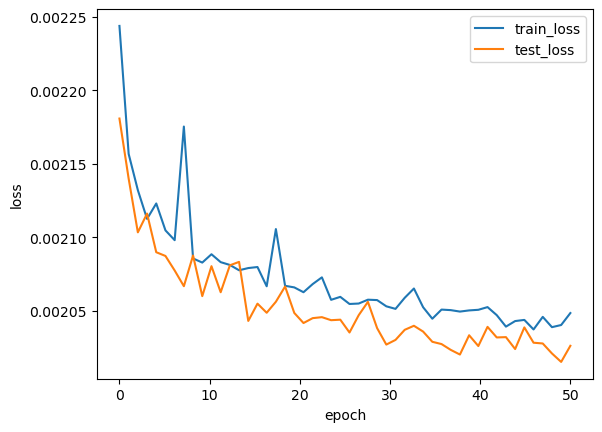

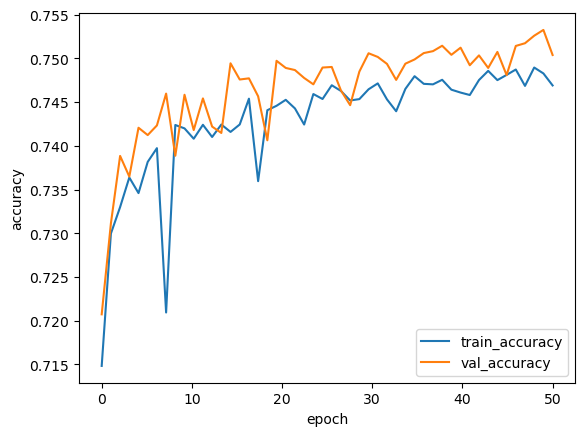

In [129]:
visualization(train_loss,val_loss,train_accuracy,val_accuracy)

In [ ]:
net.load_state_dict(torch.load("../weights/DiftNet_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("在测试集上的准确率为:%.3f"%(test_acc))

In [ ]:
def evaluate_PR(data_iter, net, loss,device="cuda"):
    n = 0
    precision_sum,recall_sum,f1_score_sum = 0.0,0.0,0.0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y.long()).sum()
        y_hat = y_hat.argmax(dim=1)
        y_hat = y_hat.squeeze().cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        precision_sum += metrics.precision_score(y,y_hat)
        recall_sum += metrics.recall_score(y,y_hat)
        f1_score_sum += metrics.f1_score(y,y_hat)
        test_l_sum += l.item()
        #n += y.shape[0]
        n+=1
    return precision_sum/n,recall_sum/n,f1_score_sum/n
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)